In [1]:
import matplotlib.pyplot as plt
import numpy as np
from HSTCOS.aux.specgen import create_spectrum
import astropy.units as u
import astropy.constants as c
from time import time
from HSTCOS.aux.ui import Formatter
fmt = Formatter()

In [2]:
# Write the docstring of the spectrum-generating function
print(create_spectrum.__doc__)


    Generates and integrates the spectrum along a given line-of sight on a regular-spaced grid
    
    Args:
    
        - dN (astropy.units.Quantity): array of column densities
        - temp (astropy.units.Quantity): quantity array containing the temperatures of the absorber
        - rad_vel (astropy.units.Quantity): radial_velocities of the absorbers
        - wavelength_lims (astropy.units.Quantity): defines the wavelengths limits in between which the spectrum is to be generated
        - spec_resolution (float): defines the spectral resolution at which the artificial spectrum is being generated. Refers to the R number = Delta lambda / lambda
        - ion_mass (astropy.units.Quantity): mass of the ion given as an astropy quantity with dimension mass
    
    
    Kwargs:
    
        - debug (boolean, optional) : Enables the debug mode in set true
        - nist_args (dict, optional) : A dictionary for a nist query. The dictionary must contain the following entries:
          

In [3]:
## Some spectra parameters
N_sightlines = 100

# Noise settings
SNR_poisson     = 10000.
SNR_gauss       = 10000.

# Spectral settings
resolution      = 120000
ion             = "SiIII"
ion_mass        = 28.08 * u.u
wavelength_lims = (1200, 1210) * u.AA

# Absorber settings
N_ISM           = 10.**np.random.uniform(15., 16., N_sightlines) / u.cm**2
T_ISM           = np.random.uniform(2000., 3000., N_sightlines) * u.K

N_HVC           = 10.**np.random.uniform(11., 12., N_sightlines) / u.cm**2
N_HVC           = np.sort(N_HVC)
N_HVC[:int(N_sightlines/3)] = 0. / u.cm**2 # set a third of the HVC absorbers to zero

V_HVC           = np.random.uniform(-200., 200., N_sightlines) * u.km / u.s
T_HVC           = np.random.uniform(2000., 3000., N_sightlines) * u.K

fmt.info("Starting the generation of HVC features ...")
## Generate the spectra
wavelengths, HVC_spectra = create_spectrum(
    dN   = N_HVC,
    temp = T_HVC,
    rad_vel= V_HVC,
    wavelength_lims=wavelength_lims,
    spec_resolution=resolution,
    ion_mass=ion_mass,
    nist_args={
        "linename":"Si III",
        "wavelength_type":"vacuum",
        "wavelength_lims":wavelength_lims
    },
    cube_out=True
)

fmt.info("Starting the generation of ISM features ...")
## Generate the spectra
wavelengths, ISM_spectra = create_spectrum(
    dN   = N_ISM,
    temp = T_ISM,
    rad_vel= np.full_like(N_ISM.value, 0.) * u.km / u.s,
    wavelength_lims=wavelength_lims,
    spec_resolution=resolution,
    ion_mass=ion_mass,
    nist_args={
        "linename":"Si III",
        "wavelength_type":"vacuum",
        "wavelength_lims":wavelength_lims
    },
    cube_out=True
)
fmt.info("Merging the spectra ...")
spectra = np.exp(-np.sum(ISM_spectra + HVC_spectra, axis=0))

# Add some noise
spectra_noise = np.random.poisson(SNR_poisson**2 * spectra, spectra.shape) / SNR_poisson**2 + np.random.normal(0., 1/SNR_gauss, spectra.shape)

fmt.info("Generation of spectra has finished!")

2024-01-31 22:43:05	[INFO] Starting the generation of HVC features ...
2024-01-31 22:43:09	[INFO] Starting the generation of ISM features ...
2024-01-31 22:43:18	[INFO] Merging the spectra ...
2024-01-31 22:43:18	[INFO] Generation of spectra has finished ...


v_HVC = -110.215260
N_ISM = 1587578922088500.250000
N_HVC = 783686558696.678101
T_HVC = 2557.514761
T_ISM = 2053.329124


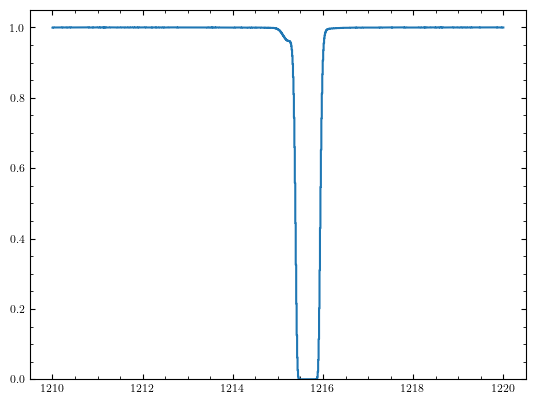

In [17]:
from HSTCOS.aux.plotting import Fdefaultplotstyle
Fdefaultplotstyle()

which_one = -10

fig, ax = plt.subplots()

ax.step(wavelengths, spectra_noise[which_one].T)
#print("v_ISM = %f" % V_ISM[which_one])
print("v_HVC = %f" % V_HVC[which_one].to_value(u.km/u.s))
print("N_ISM = %f" % N_ISM[which_one].to_value(u.cm**-2))
print("N_HVC = %f" % N_HVC[which_one].to_value(u.cm**-2))
print("T_HVC = %f" % T_HVC[which_one].to_value(u.K))
print("T_ISM = %f" % T_ISM[which_one].to_value(u.K))
ax.set_ylim(bottom=0.)
plt.show()